# Application:  Crystallization Kinetics of Amorphous $TiO_2$

The data and figures for this lesson were taken from: (Crystallization Kinetics of Amorphous TiO2, *Thin Solid Films* 519 (2010) 1649-1654)

For the next 3 weeks of lessons, we will look at several different methods of fitting data. All lessons will pull data from the literature using the digitizing functions (`selectdata()`, `cal()`) we created in the last couple of lessons.  

:::{admonition} Learning Objectives  
After completing this lesson, you should be able to:  
* perform Single Peak Fitting of XRD data using `Scipy curve_fit()`  
* integrate the area under a curve
* fit Transformation vs Time data to the Avrami Equation (see Chapter 10 of your Callister textbook for example)
* compare k and n fitting parameters to that of the paper
* recognize that literature papers can often contain mistakes. 
:::

## Application description

:::{image} ../images/09_reference.png
:width: 700px
:name: navigator
:align: center
:::
<span hidden> 
other options:
:height: 500px
</span>  
<br>

<img alt="" src="../images/09_reference.png" width=600px>

The X-ray diffraction data below is for a 180 nm sample of $TiO_2$ that is initially amorphous at room temperature. The temperature of the amorphous sample was increased as indicated to begin the crystallization process (the amorphous phase is unstable).  The presence of a peak in the Xray data indicates the presence of the crystalline phase.  The "size" of the peak (area under the curve) is proportional to the fraction of the sample that has been crystallized.  Notice that the peak no longer changes after 260 C.  This is because at this point the sample is 100% crystallized.  We can take the area under the 280 C curve to represent 100% crystalline $TiO_2$. 

:::{image} ../images/09_xrd.png
:width: 500px
:name: navigator
:align: center
:::

<img alt="" src="../images/09_xrd.png" width=600px>

Another way to collect the data is to calculate the area under the peak at a fixed temperature as a function of time.  In this way we can get the fraction of the sample that has been crystallized as a function of time. This data is shown below. 

:::{image} ../images/09_crystalliz_data.png
:width: 600px
:name: navigator
:align: center
:::

<img alt="" src="../images/09_crystalliz_data.png" width=600px>

Fitting the curves in the above figure to the [avrami equation](https://en.wikipedia.org/wiki/Avrami_equation), $Y=1-\exp(-K\ t^n)$, allows us to calculate the avrami constants, $K$ and $n$.  The authors had some trouble fitting the above data and so introduced an offset in time labeled $t_0$.  This was attributed to an incubation time.  This is not correct.  The incubation time is already part of the derivation of the avrami equation. Because of this, the values for $k$ and $n$ below are not correct.  We are going to fit the data above and correct the $k$ and $n$ values.  

:::{image} ../images/09_avrami_numbers.png
:width: 500px
:name: navigator
:align: center
:::

<img alt="" src="../images/09_avrami_numbers.png" width=600px>

:::{note}
In the Figure above, we are only interested in the filled squares (n) and the filled triangles (k).  We will compare these values to what we get by applying the avrami equation correctly.  
:::

## Load packages and define functions

Let's bring the functions `selectdata()` and `cal()` from the previous lecture to this notebook.  I've updated a few items in the functions below so use these from now on.

In [51]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.image as mpimg
import sympy as sym
import os

# pixel data stored in variable "pixel_positions"
def selectdata(path_to_image_file, filename):
    ''' 
        path_to_image_file example: r"C:/Users/Sean/images" 
        filename example: "xrd data.png"  
        pixel data stored in global variable "pixel_positions"
    '''
    plt.close('all')
    %matplotlib widget

    image_file=os.path.join(path_to_image_file, filename)
    
    #now we have 1 row and 2 columns i.e. 2 figures in a row
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2,figsize=(10, 4))


    # gridspec_kw={'width_ratios': [2, 2]} can be used above if needed

    # turn off the x, y axis on the image - the axis doesn't make sense for an image
    ax1.axis(False)
    
    img = mpimg.imread(image_file) #matplotlib
    # .add_axes([left, bottom, width, height])
    image_axis = fig.add_axes([0.015, 0, 0.5, 0.9], zorder=10, anchor=(0.5,0.5)) #zorder places figure on top of anything else in axes
    image_axis.imshow(img)
    image_axis.axis('off')
    # recall from part 1 that image files have coord in left top corner so we need to correct by the y-dimension of the file
    ydim=img.shape[0]

    # setting title and labels for ax1 (figure on the left)
    ax1.set_title('Click on the plot below to collect pixel positions.', pad=10, loc='left')
    ax1.set_xlabel('x-pixel position')
    ax1.set_ylabel('y-pixel position')

    global pixel_positions #makes pixel_positions a global variable so we have access to it outside this function
    pixel_positions = []
    def onclick(event):
        if event.button==1:
            pixel_positions.append([event.xdata,ydim-event.ydata])
            ax2.set_title(f'Last click: [{event.xdata:.3f}, {ydim-event.ydata:.3f}]')
            ax2.scatter(event.xdata, ydim-event.ydata, marker='o', c='r', edgecolor='k') #adding scatter plot
        elif event.button==3:
            tt=[[round(number[0],3),round(number[1],3)] for number in pixel_positions]
            fig.text(0.2,0.5,f'pixel positions = {tt}', fontsize=8, zorder=20,ha='left',wrap=True, backgroundcolor='white')
            fig.canvas.mpl_disconnect(cid)
        else: pass
    
    cid=fig.canvas.mpl_connect('button_press_event', onclick) 

    plt.show()
    
def cal(pixpts, plotpts, datatoconvert):    
    ''' 
        Needs numpy as np
        pixpts = list of three pixel points (typically along axes)
        plotpts = list of three points corresponding to pixpts but in plot units
        datatoconvert = list of pixel points to convert to plot coordinates
    '''
    
    xpx1, ypx1 = pixpts[0]
    x1, y1 = plotpts[0]
    xpx2, ypx2 = pixpts[1]
    x2, y2 = plotpts[1]
    xpx3, ypx3 = pixpts[2]
    x3, y3 = plotpts[2]
    
    # general solution for calibration constants
    m11=(x1*ypx2 - x1*ypx3 - x2*ypx1 + x2*ypx3 + x3*ypx1 - x3*ypx2)/(xpx1*ypx2 - xpx1*ypx3 - xpx2*ypx1 + xpx2*ypx3 + xpx3*ypx1 - xpx3*ypx2)
    m12=-(x1*xpx2 - x1*xpx3 - x2*xpx1 + x2*xpx3 + x3*xpx1 - x3*xpx2)/(xpx1*ypx2 - xpx1*ypx3 - xpx2*ypx1 + xpx2*ypx3 + xpx3*ypx1 - xpx3*ypx2)
    m21=(y1*ypx2 - y1*ypx3 - y2*ypx1 + y2*ypx3 + y3*ypx1 - y3*ypx2)/(xpx1*ypx2 - xpx1*ypx3 - xpx2*ypx1 + xpx2*ypx3 + xpx3*ypx1 - xpx3*ypx2)
    m22=-(-xpx1*y2 + xpx1*y3 + xpx2*y1 - xpx2*y3 - xpx3*y1 + xpx3*y2)/(xpx1*ypx2 - xpx1*ypx3 - xpx2*ypx1 + xpx2*ypx3 + xpx3*ypx1 - xpx3*ypx2)
    Ox=(-x1*xpx2*y3 + x1*xpx3*y2 + x2*xpx1*y3 - x2*xpx3*y1 - x3*xpx1*y2 + x3*xpx2*y1)/(x1*y2 - x1*y3 - x2*y1 + x2*y3 + x3*y1 - x3*y2)
    Oy=(x1*y2*ypx3 - x1*y3*ypx2 - x2*y1*ypx3 + x2*y3*ypx1 + x3*y1*ypx2 - x3*y2*ypx1)/(x1*y2 - x1*y3 - x2*y1 + x2*y3 + x3*y1 - x3*y2)
    
    # define our calibrated transf matrix, m_cal, and our calibrated offset, offset_cal
    m_cal=[[m11, m12],[m21,m22]]
    offset_cal=[Ox, Oy]
    
    # return as numpy arrays
    # return(np.array(m_cal), np.array(offset_cal))
    plot_data=np.array([np.matmul(m_cal, point-offset_cal) for point in np.array(datatoconvert)])

    return(plot_data)


## Reproduce the normalized intensity vs time data 

Recall that the author's of the publication were not able to fit this data without creating an additional fitting parameter (which invalidated their analysis). The python fitting routine below will have no problem fitting the data giving us a more accurate measurement of the parameters $k$ and $n$.  

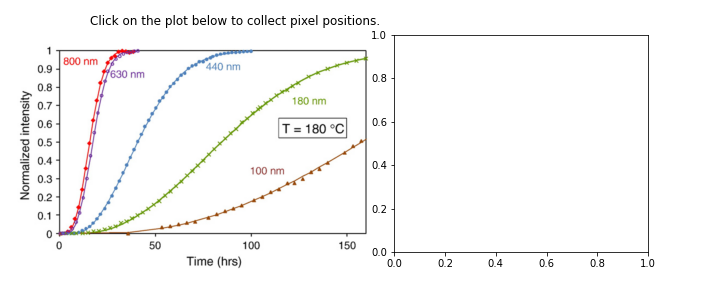

In [52]:
path="..\images"
filename='09_crystalliz_data.png'

selectdata(path, filename)

Remember to recalibrate since we have a new image.  My three points: 
```Python
[[150,0],[0,0],[0,1]]
```

In [12]:
pixel_positions

[[693.8955847422282, 82.85633877913153],
 [97.89558474222818, 82.85634469985962],
 [97.89558474222818, 461.5646780331929]]

In [13]:
# change these calibration points to your values
pixpts=pixel_positions

pltpts=[[150,0],[0,0],[0,1]]

grab points for the 180 nm data

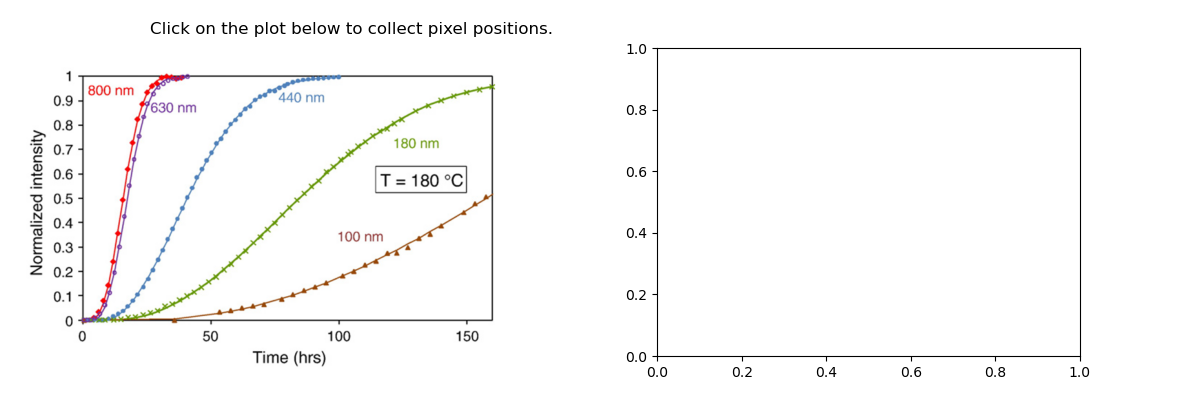

In [14]:
selectdata(path, filename)

My data looked like: 

:::{image} ../images/09_crys_pts.png
:width: 700px
:name: navigator
:align: center
:::

<img alt="" src="../images/09_crys_pts.png" width=700px>

In [15]:
dataset180=pixel_positions

Calibrate and convert your data and plot

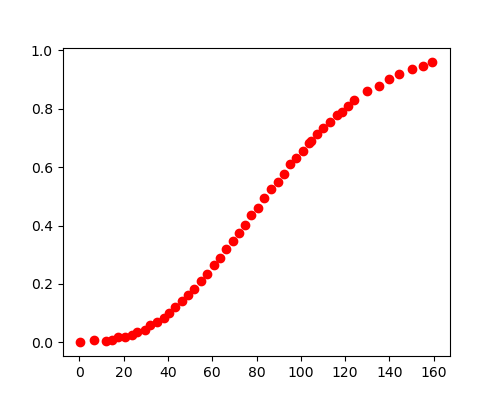

In [17]:
plot_data1=cal(pixpts, pltpts, dataset180)
    
plt.subplots(figsize=[5,4])
plt.plot(plot_data1[:,0], plot_data1[:,1], 'ro')
plt.show()

## Fit the data to the avrami equation using `curve_fit()` from scipy

Avrami equation (recall this from Callister, Chap 10)
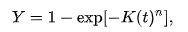

k = 1.21e-05 and n = 2.47


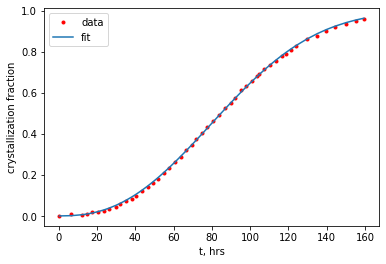

In [24]:
#just making sure that the interactive plotting is off
%matplotlib inline 
from scipy.optimize import curve_fit


# in function definition the independent variable must come first, then the fitting parameters
# notice "t" is first here, then "k" and "n"
def avrami(t,k,n): 
    return(1-np.exp(-k*t**n))

# nonlinear fits can be a bit sensitive so you may have to play with the initial guess "p0" to get a good fit
# here I used an initial guess, p0, for the parameters, k & n, rather than using bounds
popt, _ = curve_fit(avrami, plot_data1[:,0], plot_data1[:,1], p0=[1e-3, 3])

print(f'k = {popt[0]:.2e} and n = {popt[1]:.2f}')
plt.plot(plot_data1[:,0], plot_data1[:,1], 'r.', label='data');
plt.plot(plot_data1[:,0], avrami(plot_data1[:,0], *popt), label="fit");
plt.xlabel('t, hrs')
plt.ylabel('crystallization fraction')
plt.legend();
plt.show()


## Fiting with peak functions

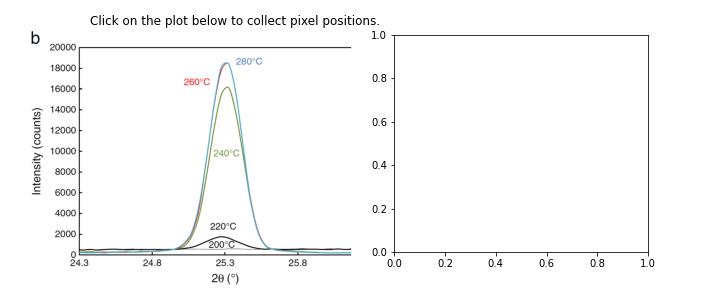

In [46]:
path="..\images"
filename='09_xrd.png'

tt=selectdata(path, filename)

Your output from above should look something like this: 

:::{image} ../images/09_pix_cal.png
:height: 370px
:name: navigator
:align: center
:::

<img alt="" src="../images/09_pix_cal.png" width=740px>

I chose points: 
```Python
[[25.8,0],[24.3,0],[24.3,20000]]
```

In [179]:
# calib pts from plot
pix_pts=pixel_positions 

plot_pts=[[25.8,0],[24.3,0],[24.3,20000]] #these should correspond to the three pts you picked and in the same order as pix_pts
pix_pts

[[600.5666666666666, 74.76069929334852],
 [119.1333333333333, 76.34958818223743],
 [120.7222222222222, 529.1829215155707]]

## Let's reproduce the 280 C curve

You can always use ctrl+"+" to increase the zoom level in your browser so you can pick points more accurately.  Ctrl+"-" will decrease your zoom level.  

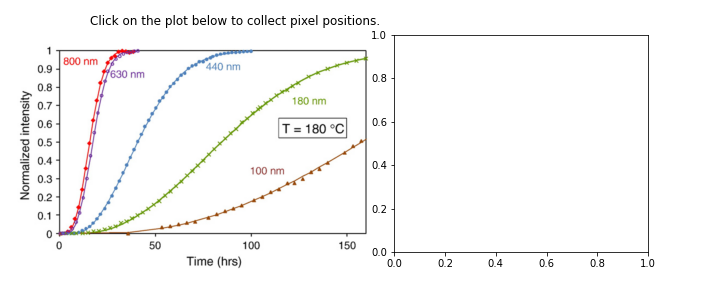

In [44]:
selectdata(path, filename)

My data looked like: 

:::{image} ../images/09_280c_pix.png
:height: 400px
:name: navigator
:align: center
:::

<img alt="" src="../images/09_280c_pix.png" width=700px>

In [183]:
pix_data280=pixel_positions

## Let's get the 240C data now

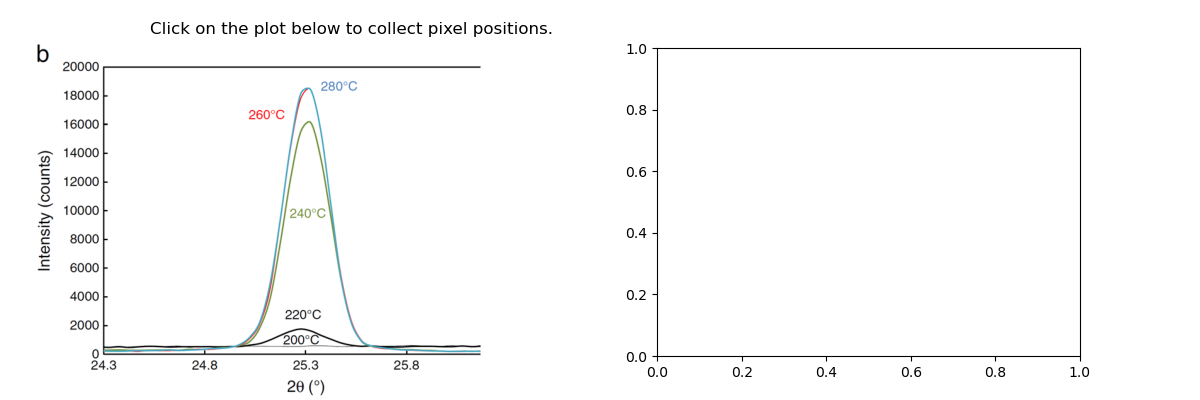

In [6]:
selectdata(path, filename)

In [185]:
pix_data240=pixel_positions

Now let's convert our pixel data to plot coordinates, $(degrees, counts)$

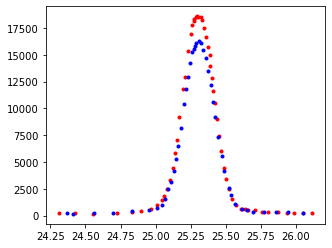

In [186]:
%matplotlib inline
plot_data1=cal(pix_pts, plot_pts, pix_data280)
plot_data2=cal(pix_pts, plot_pts, pix_data240)
    
plt.subplots(figsize=[5,4])
plt.plot(plot_data1[:,0], plot_data1[:,1], 'r.')
plt.plot(plot_data2[:,0], plot_data2[:,1], 'b.')
plt.show()

## Fit the peak data
There are several peak functions that can be used and I've given 3 more examples in the Appendix.  Below shows the Lorentzian distribution where $A$ is the amplitude, $\mu$ is the position of the peak, and $\sigma$ defines the peak width.  For our data, $x$ would be the angle, $2 \theta$. 

Lorentzian
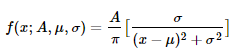

In [ ]:
from scipy.optimize import curve_fit  ## we need our curve fitting routine from scipy

# let's define a function that calculates the lorentzian
def lorentzian(x, amplitude, mean, stddev):
    return amplitude * (stddev/((x-mean)**2+stddev**2))

# let's curve fit our plot_data1. curve_fit returns two values we only need the first which we call
# popt. The second we call "__" as a throw away variable.  
# format here curve_fit(model_name, xdata, ydata, bounds_on_parameters)
popt, _ = curve_fit(lorentzian, plot_data1[:,0], plot_data1[:,1], bounds=[[0, 24, 0],[20000,26,2]])
# the bounds in the fit above help the routine find a fit.  These are given as [[lower],[upper]]
# where lower correspond to the lower bound for our three variables "amplitude", "mean", & "stddev"
# the order is taken from the order given in the function lorentzian above
# for example the amplitude, mean, and stddev have lower bounds of 0, 24, and 0 respectively 
# and a corresponding upper bound of 20000, 26, and 2 respectively.    

plt.plot(plot_data1[:,0], plot_data1[:,1], 'r.');
plt.plot(np.arange(24.25, 26.5, 0.01), lorentzian(np.arange(24.25, 26.5, 0.01), *popt));

My fit looked like:  
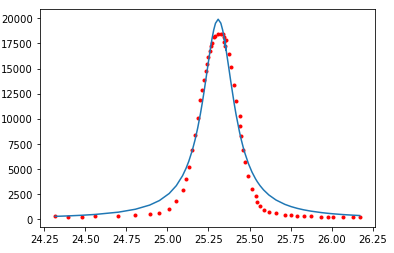
The lorentzian does not do a good job at fitting this data.  We should probably use a different function as defined in the Appendix.   

## Finding the area under a function 

Now we can work on integrating our fitted function over the peak position to find the area under the curve.  The area in this case is proportional to the fraction of crystallization.  To get the fraction crystallized, we would need to compare this area to the area under the 280 C curve.  

In [ ]:
model=lorentzian
import scipy.integrate as integrate
import scipy.special as special

# we use integrate.quad()
result = integrate.quad(lambda x: model(x, *popt), 24.5, 26.1)
result

Now let's curve fit our 240 degree data "plot_data2" and plot the fits and data for the 240 and 280 on one plot

In [ ]:
model=lorentzian

popt2, _ = curve_fit(model, plot_data2[:,0], plot_data2[:,1], bounds=[[0, 24, 0],[20000,26,2]])

plt.plot(plot_data1[:,0], plot_data1[:,1], 'r.');
plt.plot(np.arange(24.25, 26.5, 0.01), lorentzian(np.arange(24.25, 26.5, 0.01), *popt));
plt.plot(plot_data2[:,0], plot_data2[:,1], 'b.');
plt.plot(np.arange(24.25, 26.5, 0.01), lorentzian(np.arange(24.25, 26.5, 0.01), *popt2));

My output using a weighted lorentzian + gaussian model does a nice job:  
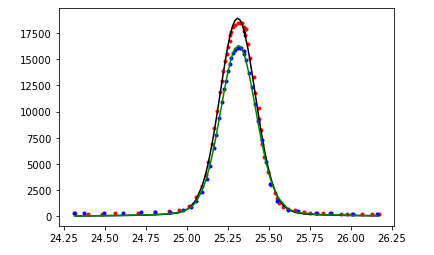

The appendix at the end of this notebook gives the model definition I used.

Integrate the 240 data

In [ ]:
result2 = integrate.quad(lambda x: model(x, *popt2), 24.5, 26.1)
result2

In [ ]:
print(f'If we take the curve at 280 C to represent fully recrystallized with an area of {result[0]:.0f}')
print(f'then we can divide all integrated areas by {result[0]:.0f}')
print(f'the normalized intensity at 240 C = {result2[0]:.0f} / {result[0]:.0f}= {result2[0]/result[0]:.2f}')

## Appendix: Other Peak Fitting Functions

### Gaussian
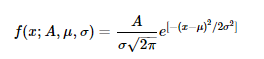

In [ ]:
from scipy.optimize import curve_fit

def gaussian(x, amplitude, mean, stddev):
    return amplitude * np.exp(-1/2*((x - mean) / stddev)**2)

popt, _ = curve_fit(gaussian, plot_data1[:,0], plot_data1[:,1], p0=[10000, 25, 0.5], bounds=[[5000, 24, 0],[20000,26,2]])

plt.plot(plot_data1[:,0], plot_data1[:,1], 'r.');
plt.plot(plot_data1[:,0], gaussian(plot_data1[:,0], *popt));

Gaussian model:
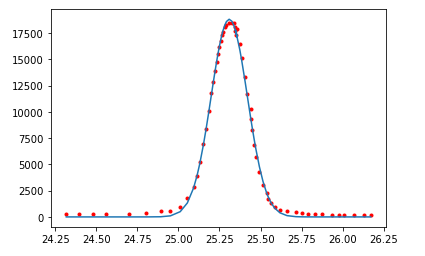

### Voigt
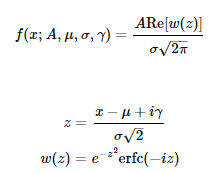

In [ ]:
from scipy.special import erfc

# def voigt(x, amplitude, mean, stddev, gamma):
#     z=(x-mean+gamma*1j)/(stddev*np.sqrt(2))
#     w=np.exp(-1*z**2)*erfc(-z*1j)
#     return amplitude * np.real(w)/(stddev*np.sqrt(2*np.pi))

def voigt(x, amplitude, mean, stddev,c):
    gamma=c*stddev #gamma is often constrained to equal stddev this line lets us fit gamma but define it relative to stddev
    z=(x-mean+gamma*1j)/(stddev*np.sqrt(2))
    w=np.exp(-1*z**2)*erfc(-z*1j)
    return amplitude * np.real(w)/(stddev*np.sqrt(2*np.pi))

popt, _ = curve_fit(voigt, plot_data1[:,0], plot_data1[:,1], bounds=[[300, 24, 0,0.01],[20000,26,2,1]])

plt.plot(plot_data1[:,0], plot_data1[:,1], 'r.');
plt.plot(plot_data1[:,0], voigt(plot_data1[:,0], *popt));

Voigt model:
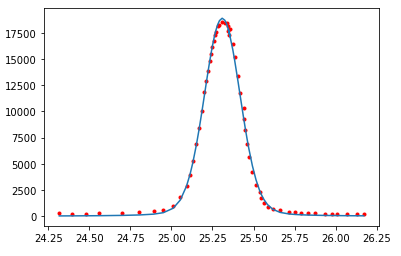

### Weighted sum of Gaussian and Lorentz
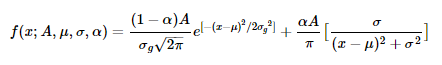


In [ ]:
def gaussian(x, amplitude, mean, stddev, alpha):
    stddevg=stddev/(2*np.log(2))
    return (1-alpha)*amplitude * np.exp(-1/2*((x - mean) / stddevg)**2)

def lorentzian(x, amplitude, mean, stddev, alpha):
    return alpha*amplitude * (stddev/((x-mean)**2+stddev**2))

def model(x,amplitude, mean, stddev, alpha):
    return(gaussian(x,amplitude, mean, stddev, alpha)+lorentzian(x,amplitude, mean, stddev, alpha))

popt, _ = curve_fit(model, plot_data1[:,0], plot_data1[:,1], bounds=[[0, 24, 0,0],[20000,26,2,1]])

plt.plot(plot_data1[:,0], plot_data1[:,1], 'r.');
plt.plot(plot_data1[:,0], model(plot_data1[:,0], *popt));

Gaussian + Lorentzian fit
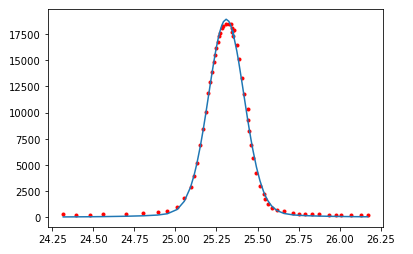

## Exercises

### Problem 1

Copy the functions selectdata() and cal() as well as the needed import statements into a text file with the extension (.py). With a new notebook, import these functions and use them to ...

### Repeat this for your 630 nm data and plot everything (180 & 630 & fits) on one plot

### Compare your values for n for the 180 and 630 data to that of the paper.  
Paper fitting values for n.   180nm:  n = 2.25 and 630nm: n=2.5

Why are your answers different than the values from the paper?  Because the authors performed a fit using a bad function.  They chose to fit $y=1-exp(-k  (t-t_0)^n)$  rather than the simple avrami equation $y=1-exp(-k  t^n)$.  

They added the $t_0$ parameter because they could not fit the data without it.  They claimed that $t_0$ represented an incubation time for nucleation but this is nonsense since this is already built into the Avrami equation!  See notes on the avrami equation in your Callister text. 

### Problem 3

Following the steps in the example above for the Lorentzian distrubution, fit your plot_data1 and plot_data2 to a Gaussian distribution.  The equation is: 
$$f(x, A, \mu, \sigma)= A \ {\rm e}^{-(x-\mu)^2/(2\ \sigma^2)}$$